# Imports

In [1]:
import joblib

import constants.paths as pth
from src.preprocessing import preprocess_data  # noqa: F401
from src.utils.load_data import load_data

In [2]:
data_to_predict = load_data(pth.NEW_LOANS_PATH)
scaled_data_to_predict, _ = preprocess_data(data_to_predict)

In [3]:
# Make predictions
model_name = "random_forest"  # Change as needed
model = joblib.load(pth.MODELS_DIR / f"{model_name}.pkl")  # Load your trained model

proba_predictions = model.predict_proba(scaled_data_to_predict)[
    :, 1
]  # Probability of the positive class (default probability)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    1.8s finished


In [4]:
data_to_predict["predicted_default_proba"] = proba_predictions

In [5]:
# We compute the breake-even interest rate for each loan
data_to_predict["breakeven_interest_rate"] = data_to_predict[
    "predicted_default_proba"
] / (1 - data_to_predict["predicted_default_proba"])

In [6]:
data_to_predict[data_to_predict["predicted_default_proba"] > 0.5]

,id,sex,employment,married,income,signal2,predicted_default_proba,breakeven_interest_rate
7,8,M,unemployed,1,0,0.000000,0.730890,2.715949
11,12,M,unemployed,0,0,0.000000,0.760191,3.169981
24,25,F,retired,1,2396,0.167527,0.710000,2.448276
25,26,M,unemployed,1,0,0.623454,0.919215,11.378599
36,37,F,student,1,0,0.258638,0.623333,1.654867
...,...,...,...,...,...,...,...,...
99904,99905,F,unemployed,0,0,0.385095,0.864786,6.395687
99927,99928,F,student,0,0,0.873871,0.856324,5.960117
99951,99952,M,student,0,3966,0.000000,0.526667,1.112676
99961,99962,M,student,0,0,0.298729,0.633530,1.728734


The function
$$
f : x \mapsto \frac{x}{1-x}
$$
is strictly growing on $[0,1[$ and $f(\frac{1}{2})=1$.

Thus, any predicted default probability above $0.5$ gives a break even interest rate above $100\%$. We cannot fix interest rates above $100\%$.

0.1    0.000
0.9    0.335
Name: predicted_default_proba, dtype: float64


<Axes: >

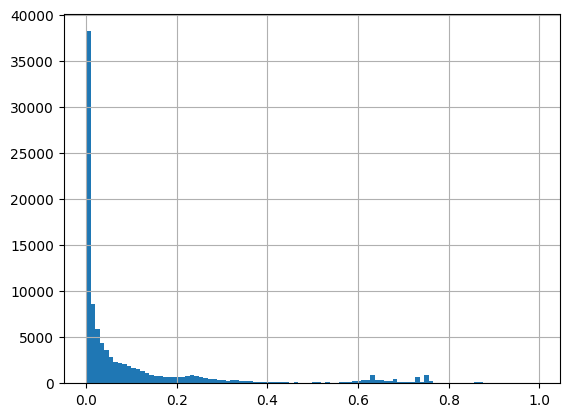

In [7]:
print(data_to_predict["predicted_default_proba"].quantile([0.1, 0.90]))
data_to_predict["predicted_default_proba"].hist(bins=100)